In [ ]:
# experiment.py
import torch
import torch.nn as nn
import numpy as np
import random

# Set ALL the seeds for reproducibility
def set_seed(seed=42):
    """Set all random seeds for complete reproducibility."""
    # Python's built-in random module
    random.seed(seed)
    
    # NumPy random
    np.random.seed(seed)
    
    # PyTorch CPU random
    torch.manual_seed(seed)
    
    # PyTorch CUDA random (if available)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)  # For multi-GPU
        
    # Make CuDNN deterministic for reproducibility (may impact performance)
    if torch.backends.cudnn.is_available():
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False

if __name__ == "__main__":
    set_seed(42)
    print("Seeds set. Ready for deterministic exploration.")

In [56]:
if __name__ == "__main__":
    set_seed(42)
    a = torch.randn(3)
    print(a)
    set_seed(42)
    b = torch.randn(3)
    print(b)
    print(f"Identical? {torch.equal(a, b)}")  # Should be True

tensor([0.3367, 0.1288, 0.2345])
tensor([0.3367, 0.1288, 0.2345])
Identical? True


In [57]:
class MultiHeadAttention(nn.Module):
    def __init__(self, d_model=16, n_heads=2):
        super().__init__()
        self.d_model = d_model
        self.n_heads = n_heads
        self.d_head = d_model // n_heads  # 16/2 = 8 dims per head
        
        # Create Q, K, V projections
        self.W_Q = nn.Linear(d_model, d_model)
        self.W_K = nn.Linear(d_model, d_model)
        self.W_V = nn.Linear(d_model, d_model)
        self.W_O = nn.Linear(d_model, d_model)
        
    def forward(self, x):
        batch_size, seq_len, d_model = x.shape
        
        # Project to Q, K, V
        Q = self.W_Q(x)  # [batch, seq, d_model]
        K = self.W_K(x)  # You implement
        V = self.W_V(x) # You implement
        
        # Reshape for multi-head attention
        # We need [batch, n_heads, seq, d_head]
        Q = Q.view(batch_size, seq_len, self.n_heads, self.d_head).transpose(1, 2)
        K = K.view(batch_size, seq_len, self.n_heads, self.d_head).transpose(1, 2) # You reshape K the same way
        V = V.view(batch_size, seq_len, self.n_heads, self.d_head).transpose(1, 2)  # You reshape V the same way
        
            # Compute attention scores
        scores = Q @ K.transpose(2,3) / (self.d_head ** 0.5)        
        # Apply attention to values
        attn_weights = torch.softmax(scores, dim=-1)  # How do you turn scores into probabilities?
        self.last_attn_weights = attn_weights  # Save for analysis!
        attn_output = attn_weights @ V  # How do you apply weights to V?
        attn_output = attn_output.transpose(1,2).reshape(batch_size, seq_len, d_model)

        attn_output = self.W_O(attn_output)
        return attn_output, attn_weights
        


In [58]:
class TransformerLayer(nn.Module):
    def __init__(self, d_model=16, n_heads=2, d_ff=64):
        super().__init__()
        self.attn = MultiHeadAttention(d_model, n_heads)
        self.norm1 = nn.LayerNorm(d_model)
        self.norm2 = nn.LayerNorm(d_model)
        
        # Feedforward network
        self.ff = nn.Sequential(
            nn.Linear(d_model, d_ff),
            nn.ReLU(),
            nn.Linear(d_ff, d_model)
        )
        
    def forward(self, x):
        # Attention block with residual
        attn_out, attn_weights = self.attn(x)
        x = x + attn_out  # How do you combine x and attn_out (residual)?
        x = self.norm1(x)  # Apply layer norm
        
        # Feedforward block with residual  
        ff_out = self.ff(x)
        x = x + ff_out  # Residual connection
        x = self.norm2(x)  # Layer norm
        
        return x, attn_weights

In [ ]:
class TinyTransformer(nn.Module):
    def __init__(self, d_model=16, n_heads=2, n_layers=2, vocab_size=10, seq_len=8):
        super().__init__()
        self.d_model = d_model
        self.seq_len = seq_len
        
        self.token_embed = nn.Embedding(vocab_size, d_model)
        self.pos_embed = nn.Embedding(seq_len, d_model)
        
        self.layers = nn.ModuleList([
            TransformerLayer(d_model, n_heads, d_ff=4*d_model) 
            for _ in range(n_layers)
        ])
        
        self.output = nn.Linear(d_model, vocab_size)
        
    def forward(self, x):
        batch_size, seq_len = x.shape
        
        # Get embeddings
        tok_emb = self.token_embed(x)
        # Create positions on the same device as x
        positions = torch.arange(seq_len, device=x.device).unsqueeze(0).expand(batch_size, -1)
        pos_emb = self.pos_embed(positions)
        
        # Combine
        embeddings = tok_emb + pos_emb
        
        # Pass through layers, collecting attention weights
        hidden = embeddings
        attention_maps = []
        for layer in self.layers:
            hidden, attn_weights = layer(hidden)
            attention_maps.append(attn_weights)
            
        logits = self.output(hidden)
        return logits, attention_maps

In [60]:
set_seed(42)
model = TinyTransformer()
test_input = torch.randint(0, 10, (2, 8))
logits, attn_maps = model(test_input)
print(f"Logits: {logits.shape}")
print(f"Attention maps: {len(attn_maps)} layers, each {attn_maps[0].shape}")

Logits: torch.Size([2, 8, 10])
Attention maps: 2 layers, each torch.Size([2, 2, 8, 8])


In [61]:
def create_probe_sequences():
    """Create sequences to test what neurons respond to"""
    probes = {}
    
    # Position probes - same token in different positions
    probes['position'] = torch.tensor([[5,5,5,5,5,5,5,5]])  # All same token
    
    # Token identity probes - different tokens  
    probes['token'] = torch.tensor([[0,1,2,3,4,5,6,7]])  # Different tokens
    
    # Specific position-token combinations
    # Token 7 at position 3 only
    probes['position_token'] = torch.tensor([[0,0,0,7,0,0,0,0]])
    
    return probes

# ============================================================================
# MECHANISTIC INTERPRETABILITY TOOLKIT
# Day 1: Core observation and intervention tools
# ============================================================================

import matplotlib.pyplot as plt
import seaborn as sns
from typing import Dict, List, Optional, Tuple
import torch.nn.functional as F

In [62]:
# 1. ACTIVATION CACHE - Spy on the forward pass
class ActivationCache:
    """
    Non-invasive activation capture using PyTorch hooks.
    This lets us observe what happens inside the model during forward passes.
    
    Key concepts:
    - Hooks don't modify the computation, just observe
    - We detach tensors to avoid memory issues
    - Can capture any layer's input/output
    """
    def __init__(self):
        self.activations = {}
        self.hooks = []
        
    def create_hook(self, name):
        """Create a hook function that stores activations."""
        def hook(module, input, output):
            # TODO(human): Store the activation, but detach it from the computation graph
            # Why detach? To save memory and prevent gradient tracking
            # Hint: if output is a tuple (like attention returns), handle both cases
            # Store in self.activations[name]
            if isinstance(output, tuple):
                self.activations[name] = output[0].clone().detach()
            else:
                self.activations[name] = output.clone().detach()

        return hook
    
    def register_hooks(self, model):
        """Register hooks on specific layers we want to observe."""
        # Hook into attention layers
        for i, layer in enumerate(model.layers):
            # Attention outputs
            hook = layer.attn.register_forward_hook(self.create_hook(f'attn_{i}'))
            self.hooks.append(hook)
            
            # TODO(human): Also register a hook for the feedforward layer
            # layer.ff is the feedforward network
            # Name it f'ff_{i}'
            hook = layer.ff.register_forward_hook(self.create_hook(f'ff_{i}'))
            self.hooks.append(hook)
            
        # Hook into embeddings
        hook = model.token_embed.register_forward_hook(self.create_hook('embed'))
        self.hooks.append(hook)
        
        # Hook into final output
        hook = model.output.register_forward_hook(self.create_hook('logits'))
        self.hooks.append(hook)
        
        return self
    
    def clear(self):
        """Clear stored activations."""
        self.activations = {}
    
    def remove_hooks(self):
        """Remove all hooks from the model."""
        for hook in self.hooks:
            hook.remove()
        self.hooks = []
        
    def __getitem__(self, key):
        """Easy access to activations."""
        return self.activations[key]

In [ ]:
# 2. LOGIT LENS - Decode hidden states into vocabulary
def logit_lens(model, hidden_states):
    """
    The logit lens lets us interpret any hidden state as a distribution over tokens.
    
    Key insight: The residual stream at ANY point contains interpretable information!
    We can decode it by applying the final output projection.
    
    Args:
        model: The transformer model
        hidden_states: Activations from any layer [batch, seq, d_model]
    
    Returns:
        logits: Distribution over vocabulary [batch, seq, vocab_size]
    """
    # Since TinyTransformer doesn't have a final LN before output,
    # we directly project through the output layer
    return model.output(hidden_states)

def visualize_logit_lens(model, input_ids, cache, top_k=3):
    """
    Visualize what tokens the model is 'thinking about' at each layer.
    
    Shows top-k predicted tokens at each position and layer.
    """
    import matplotlib.pyplot as plt
    
    # Vocabulary for visualization (using indices as tokens since vocab_size=10)
    vocab = [str(i) for i in range(10)]
    
    # Layers to analyze
    layers_to_check = ['embed', 'attn_0', 'ff_0', 'attn_1', 'ff_1', 'logits']
    
    batch_size, seq_len = input_ids.shape
    
    # Create visualization
    fig, axes = plt.subplots(len(layers_to_check), 1, figsize=(12, 2*len(layers_to_check)))
    if len(layers_to_check) == 1:
        axes = [axes]
    
    for layer_idx, layer_name in enumerate(layers_to_check):
        if layer_name in cache.activations:
            # Get activations for this layer
            activations = cache.activations[layer_name]
            
            if layer_name == 'logits':
                # Already logits, no need to apply logit lens
                logits = activations
            else:
                # Apply logit lens to get predictions
                logits = logit_lens(model, activations)
            
            # Get top-k predictions for each position
            probs = torch.softmax(logits[0], dim=-1)  # First batch item
            top_probs, top_indices = torch.topk(probs, k=min(top_k, 10), dim=-1)
            
            # Create text representation
            ax = axes[layer_idx]
            ax.set_title(f"Layer: {layer_name}")
            ax.set_xlim(0, seq_len)
            ax.set_ylim(0, top_k)
            ax.set_xlabel("Position")
            ax.set_ylabel("Top Predictions")
            
            # Plot top predictions at each position
            for pos in range(seq_len):
                for k in range(min(top_k, 10)):
                    token_id = top_indices[pos, k].item()
                    prob = top_probs[pos, k].item()
                    color_intensity = prob  # Use probability for color intensity
                    
                    # Display token with probability
                    ax.text(pos + 0.5, top_k - k - 0.5, 
                           f"{vocab[token_id]}\n{prob:.2f}",
                           ha='center', va='center',
                           fontsize=8,
                           bbox=dict(boxstyle="round,pad=0.3", 
                                   facecolor=plt.cm.Blues(color_intensity),
                                   alpha=0.7))
            
            ax.set_xticks(range(seq_len + 1))
            ax.set_yticks([])
            ax.grid(True, axis='x', alpha=0.3)
    
    plt.suptitle("Logit Lens: Model's Token Predictions Across Layers", fontsize=14, y=1.02)
    plt.tight_layout()
    plt.show()
    
    return fig

In [64]:
# Test the logit lens - see what the model is "thinking"
set_seed(42)
model = TinyTransformer()
cache = ActivationCache()
cache.register_hooks(model)

# Create a simple test sequence
test_input = torch.tensor([[1, 2, 3, 4, 1, 2, 3, 4]])  # Repeating pattern
print(f"Input sequence: {test_input[0].tolist()}")
print(f"Input shape: {test_input.size()}")
# Run forward pass to collect activations
logits, attn_maps = model(test_input)

# Now use logit lens at different layers
print("\n🔍 Logit Lens Analysis - What is the model thinking?")
print("-" * 50)

# Check embeddings
embed_logits = logit_lens(model, cache['embed'])
print(f"After embeddings, shape: {embed_logits.shape}")
top_tokens_embed = embed_logits[0, -1].argmax()  # Last position prediction
print(f"  Top predicted token at last position: {top_tokens_embed.item()}")

# Check after first attention layer
attn0_logits = logit_lens(model, cache['attn_0'])
top_tokens_attn0 = attn0_logits[0, -1].argmax()
print(f"\nAfter attention layer 0:")
print(f"  Top predicted token at last position: {top_tokens_attn0.item()}")

# Check after first feedforward
ff0_logits = logit_lens(model, cache['ff_0'])
top_tokens_ff0 = ff0_logits[0, -1].argmax()
print(f"\nAfter feedforward layer 0:")
print(f"  Top predicted token at last position: {top_tokens_ff0.item()}")

# Final output
final_top = logits[0, -1].argmax()
print(f"\nFinal model output:")
print(f"  Top predicted token at last position: {final_top.item()}")

print("\n💡 Notice: Even a random model has preferences at each layer!")
print("This is evidence of pre-existing structure in random networks.")

# Clean up
cache.remove_hooks()

Input sequence: [1, 2, 3, 4, 1, 2, 3, 4]
Input shape: torch.Size([1, 8])

🔍 Logit Lens Analysis - What is the model thinking?
--------------------------------------------------
After embeddings, shape: torch.Size([1, 8, 10])
  Top predicted token at last position: 1

After attention layer 0:
  Top predicted token at last position: 6

After feedforward layer 0:
  Top predicted token at last position: 6

Final model output:
  Top predicted token at last position: 8

💡 Notice: Even a random model has preferences at each layer!
This is evidence of pre-existing structure in random networks.


In [ ]:
# 3. ATTENTION VISUALIZATION - See what the model is looking at
def visualize_attention_patterns(attention_weights, input_ids=None, layer_idx=0, head_idx=None):
    """
    Visualize attention patterns to understand information flow.
    
    Common patterns to look for:
    - Diagonal: attending to self
    - Previous token: attending to the token before
    - Induction: copying patterns from earlier in sequence
    - Global: attending to specific positions (e.g., first token)
    
    Args:
        attention_weights: [batch, n_heads, seq_len, seq_len] or [batch, seq_len, seq_len]
        input_ids: Optional token ids for labels
        layer_idx: Which layer we're visualizing
        head_idx: Specific head to visualize (None = average all heads)
    """
    # Handle different shapes
    if len(attention_weights.shape) == 4:
        batch_size, n_heads, seq_len, _ = attention_weights.shape
        if head_idx is not None:
            attn = attention_weights[0, head_idx].detach().cpu().numpy()
            title = f"Layer {layer_idx}, Head {head_idx}"
        else:
            # Average over heads
            attn = attention_weights[0].mean(dim=0).detach().cpu().numpy()
            title = f"Layer {layer_idx}, Averaged Heads"
    else:
        attn = attention_weights[0].detach().cpu().numpy()
        title = f"Layer {layer_idx}"
    
    # Create visualization
    plt.figure(figsize=(8, 6))
    sns.heatmap(attn, cmap='Blues', cbar=True, square=True)
    plt.title(title)
    plt.xlabel("Position (attending to)")
    plt.ylabel("Position (attending from)")
    
    # Add token labels if provided
    if input_ids is not None:
        tokens = input_ids[0].cpu().numpy()
        plt.xticks(range(len(tokens)), tokens, rotation=45)
        plt.yticks(range(len(tokens)), tokens)
    
    plt.tight_layout()
    plt.show()

def identify_attention_patterns(attention_weights, threshold=0.1):
    """
    Automatically identify common attention patterns.
    """
    # Handle both 3D and 4D tensors
    if len(attention_weights.shape) == 4:
        # [batch, n_heads, seq, seq]
        batch, n_heads, seq_len, _ = attention_weights.shape
        attn = attention_weights[0]  # Take first batch item
    else:
        # [batch, seq, seq] - extract seq_len here for 3D case
        batch, seq_len, _ = attention_weights.shape
        attn = attention_weights[0].unsqueeze(0)  # Add head dimension
        n_heads = 1

    patterns = {
        'diagonal': [],
        'previous': [],
        'first': [],
        'uniform': []
    }

    for head_idx in range(attn.shape[0]):
        head_attn = attn[head_idx]  # [seq, seq]

        # Diagonal (self-attention)
        diagonal_avg = head_attn.diagonal().mean().item()
        patterns['diagonal'].append(diagonal_avg)

        # Previous token (offset=-1 diagonal)
        if seq_len > 1:
            prev_diag = head_attn.diagonal(offset=-1)
            previous_avg = prev_diag.mean().item() if len(prev_diag) > 0 else 0
        else:
            previous_avg = 0
        patterns['previous'].append(previous_avg)

        # First token attention (column 0)
        first_avg = head_attn[:, 0].mean().item()
        patterns['first'].append(first_avg)

        # Uniformity (lower std = more uniform)
        # Perfect uniform would be 1/seq_len everywhere, std would be 0
        uniformity = 1 - head_attn.std().item()  # Simple std across all values
        patterns['uniform'].append(uniformity)

    return patterns

In [66]:
# Test attention pattern identification
set_seed(42)
model = TinyTransformer()

# Create different test sequences to see different patterns
test_sequences = {
    'repeating': torch.tensor([[1, 2, 3, 4, 1, 2, 3, 4]]),
    'ascending': torch.tensor([[0, 1, 2, 3, 4, 5, 6, 7]]),
    'constant': torch.tensor([[5, 5, 5, 5, 5, 5, 5, 5]])
}

print("🔍 Attention Pattern Analysis")
print("=" * 50)

for seq_name, seq in test_sequences.items():
    print(f"\n{seq_name.upper()} sequence: {seq[0].tolist()}")
    print("-" * 40)
    
    # Get attention patterns
    logits, attn_maps = model(seq)
    
    # Analyze each layer
    for layer_idx, attn in enumerate(attn_maps):
        patterns = identify_attention_patterns(attn)
        
        print(f"\nLayer {layer_idx}:")
        for head_idx in range(len(patterns['diagonal'])):
            print(f"  Head {head_idx}:")
            print(f"    Self-attention: {patterns['diagonal'][head_idx]:.3f}")
            print(f"    Previous token: {patterns['previous'][head_idx]:.3f}")
            print(f"    First token:    {patterns['first'][head_idx]:.3f}")
            print(f"    Uniformity:     {patterns['uniform'][head_idx]:.3f}")
            
            # Identify dominant pattern
            scores = {
                'self': patterns['diagonal'][head_idx],
                'previous': patterns['previous'][head_idx],
                'first': patterns['first'][head_idx]
            }
            dominant = max(scores, key=scores.get)
            print(f"    → Dominant: {dominant} attention")

print("\n💡 Even random models show structured attention patterns!")

🔍 Attention Pattern Analysis

REPEATING sequence: [1, 2, 3, 4, 1, 2, 3, 4]
----------------------------------------

Layer 0:
  Head 0:
    Self-attention: 0.138
    Previous token: 0.105
    First token:    0.141
    Uniformity:     0.941
    → Dominant: first attention
  Head 1:
    Self-attention: 0.078
    Previous token: 0.117
    First token:    0.087
    Uniformity:     0.930
    → Dominant: previous attention

Layer 1:
  Head 0:
    Self-attention: 0.119
    Previous token: 0.143
    First token:    0.129
    Uniformity:     0.937
    → Dominant: previous attention
  Head 1:
    Self-attention: 0.117
    Previous token: 0.117
    First token:    0.109
    Uniformity:     0.968
    → Dominant: self attention

ASCENDING sequence: [0, 1, 2, 3, 4, 5, 6, 7]
----------------------------------------

Layer 0:
  Head 0:
    Self-attention: 0.121
    Previous token: 0.121
    First token:    0.127
    Uniformity:     0.913
    → Dominant: first attention
  Head 1:
    Self-attention: 0.

In [67]:
# TEST YOUR IMPLEMENTATION - Morning checkpoint
def test_hooks_and_cache():
    """Test that your hook implementation works correctly."""
    set_seed(42)
    model = TinyTransformer()
    cache = ActivationCache()
    
    # Register hooks
    cache.register_hooks(model)
    
    # Run forward pass
    test_input = torch.randint(0, 10, (1, 8))
    logits, attn_maps = model(test_input)
    
    # Check that activations were captured
    print("Captured activations:")
    for key in cache.activations:
        if isinstance(cache.activations[key], tuple):
            print(f"  {key}: {cache.activations[key][0].shape}")
        else:
            print(f"  {key}: {cache.activations[key].shape}")
    
    # Clean up
    cache.remove_hooks()
    return cache

# Run this after implementing the TODOs above
cache = test_hooks_and_cache()

Captured activations:
  embed: torch.Size([1, 8, 16])
  attn_0: torch.Size([1, 8, 16])
  ff_0: torch.Size([1, 8, 16])
  attn_1: torch.Size([1, 8, 16])
  ff_1: torch.Size([1, 8, 16])
  logits: torch.Size([1, 8, 10])


In [68]:
# Let's test your hook implementation!
set_seed(42)
model = TinyTransformer()
cache = ActivationCache()

# Register hooks
cache.register_hooks(model)

# Run forward pass
test_input = torch.randint(0, 10, (1, 8))
print(f"Input sequence: {test_input[0].tolist()}")

logits, attn_maps = model(test_input)

# Check what we captured
print("\n✅ Successfully captured activations:")
for key in sorted(cache.activations.keys()):
    act = cache.activations[key]
    if isinstance(act, tuple):
        shape = act[0].shape if hasattr(act[0], 'shape') else type(act[0])
    else:
        shape = act.shape if hasattr(act, 'shape') else type(act)
    print(f"  {key}: {shape}")

# Clean up
cache.remove_hooks()

print("\n🎉 Hooks working perfectly! You can now observe any layer's activations.")

Input sequence: [7, 7, 0, 5, 5, 3, 0, 3]

✅ Successfully captured activations:
  attn_0: torch.Size([1, 8, 16])
  attn_1: torch.Size([1, 8, 16])
  embed: torch.Size([1, 8, 16])
  ff_0: torch.Size([1, 8, 16])
  ff_1: torch.Size([1, 8, 16])
  logits: torch.Size([1, 8, 10])

🎉 Hooks working perfectly! You can now observe any layer's activations.


In [ ]:
# ============================================================================
# PART 2: INTERVENTION TOOLS - Understanding causality
# ============================================================================

# 4. ACTIVATION PATCHING - Test causal importance
def activation_patching(model, clean_input, corrupted_input, layer_name, cache_clean, cache_corrupted, metric_fn):
    """
    Activation patching reveals which components are causally important.
    
    Method:
    1. Run model on corrupted input (e.g., with critical info removed)
    2. Run model on clean input
    3. Replace specific activation from corrupted run with clean activation
    4. If performance recovers, that activation was crucial!
    
    Args:
        model: The transformer model
        clean_input: Input with correct information
        corrupted_input: Input with information removed/corrupted
        layer_name: Which activation to patch (e.g., 'attn_0', 'ff_1')
        cache_clean: ActivationCache from clean run
        cache_corrupted: ActivationCache from corrupted run (for consistency, not used)
        metric_fn: Function to measure performance (higher = better)
    
    Returns:
        patched_metric: Performance after patching
        baseline_metric: Performance without patching (corrupted)
        clean_metric: Performance on clean input (upper bound)
    """
    # Get clean activation for patching
    clean_activation = cache_clean[layer_name]
    
    # Create a patching hook that will replace activations during forward pass
    def patching_hook(module, input, output):
        if isinstance(output, tuple):
            # For attention layers that return (output, attention_weights)
            output = (clean_activation, output[1])
        else:
            # For other layers that return just the activation
            output = clean_activation
        return output
    
    # Register the patching hook on the appropriate layer
    target_module = None
    if 'attn' in layer_name:
        layer_idx = int(layer_name.split('_')[1])
        target_module = model.layers[layer_idx].attn
    elif 'ff' in layer_name:
        layer_idx = int(layer_name.split('_')[1])
        target_module = model.layers[layer_idx].ff
    elif layer_name == 'embed':
        target_module = model.token_embed
    
    # Register hook and run patched forward pass
    hook_handle = target_module.register_forward_hook(patching_hook)
    
    with torch.no_grad():
        # Run on corrupted input with patching
        patched_output, _ = model(corrupted_input)
        patched_metric = metric_fn(patched_output, corrupted_input)
        
        # Clean up hook
        hook_handle.remove()
        
        # Get baseline metrics
        corrupted_output, _ = model(corrupted_input)
        baseline_metric = metric_fn(corrupted_output, corrupted_input)
        
        clean_output, _ = model(clean_input)
        clean_metric = metric_fn(clean_output, clean_input)
    
    return patched_metric, baseline_metric, clean_metric

# 5. ABLATION STUDIES - Remove components to test importance
def ablate_neurons(model, layer_name, neuron_indices, replacement='zero', mean_cache=None):
    """
    Ablate (remove) specific neurons to test their importance.
    
    Replacement strategies:
    - 'zero': Set activations to 0
    - 'mean': Replace with mean activation (requires mean_cache)
    - 'random': Replace with random noise
    
    Args:
        model: The transformer model
        layer_name: Which layer to ablate (e.g., 'ff_0')
        neuron_indices: List of neuron indices to ablate
        replacement: How to replace ablated neurons
        mean_cache: Dict with mean activations for each layer (required for 'mean' strategy)
    """
    def ablation_hook(module, input, output):
        # Handle tuple case (attention layers)
        if isinstance(output, tuple):
            # Clone the first element (the actual activation)
            modified = output[0].clone()
            # Apply ablation to specific neurons
            if replacement == 'zero':
                modified[..., neuron_indices] = 0
            elif replacement == 'mean':
                if mean_cache and layer_name in mean_cache:
                    # Replace with pre-computed mean values for those specific neurons
                    mean_values = mean_cache[layer_name][neuron_indices]
                    # Broadcast mean values to match modified shape [batch, seq, hidden]
                    modified[..., neuron_indices] = mean_values
                else:
                    # Fallback: use mean across current batch and sequence
                    mean_val = modified.mean(dim=(0, 1))  # [hidden]
                    modified[..., neuron_indices] = mean_val[neuron_indices]
            elif replacement == 'random':
                modified[..., neuron_indices] = torch.randn_like(modified[..., neuron_indices])
            # Return as tuple with unchanged attention weights
            return (modified, output[1])
        else:
            # Clone for regular layers
            modified = output.clone()
            # Apply ablation to specific neurons
            if replacement == 'zero':
                modified[..., neuron_indices] = 0
            elif replacement == 'mean':
                if mean_cache and layer_name in mean_cache:
                    # Replace with pre-computed mean values for those specific neurons
                    mean_values = mean_cache[layer_name][neuron_indices]
                    # Broadcast to match shape [batch, seq, hidden]
                    modified[..., neuron_indices] = mean_values
                else:
                    # Fallback: use mean across current batch and sequence
                    mean_val = modified.mean(dim=(0, 1))  # [hidden]
                    modified[..., neuron_indices] = mean_val[neuron_indices]
            elif replacement == 'random':
                modified[..., neuron_indices] = torch.randn_like(modified[..., neuron_indices])
            return modified
    
    # Find the target module
    target_module = None
    if 'attn' in layer_name:
        layer_idx = int(layer_name.split('_')[1])
        target_module = model.layers[layer_idx].attn
    elif 'ff' in layer_name:
        layer_idx = int(layer_name.split('_')[1])
        target_module = model.layers[layer_idx].ff
    elif layer_name == 'embed':
        target_module = model.token_embed
    
    # Register and return the hook handle
    if target_module:
        return target_module.register_forward_hook(ablation_hook)
    return None

def compute_mean_cache(model, dataloader=None):
    """
    Compute mean activations for each layer across a dataset.
    
    Args:
        model: The transformer model
        dataloader: DataLoader or list of input tensors (if None, uses random data)
    
    Returns:
        mean_cache: Dict mapping layer names to mean activations with shape [hidden]
    """
    if dataloader is None:
        # Create some random data as fallback
        dataloader = [torch.randint(0, 10, (4, 8)) for _ in range(10)]
    
    # Set up activation cache
    cache = ActivationCache()
    cache.register_hooks(model)
    
    # Accumulate activations
    activation_sums = {}
    count = 0
    
    with torch.no_grad():
        for batch in dataloader:
            if isinstance(batch, (tuple, list)):
                batch = batch[0]  # Handle (input, label) format
            
            # Forward pass
            _ = model(batch)
            
            # Accumulate activations
            for key, act in cache.activations.items():
                if isinstance(act, tuple):
                    act = act[0]
                
                if key not in activation_sums:
                    # Initialize with zeros of correct shape [hidden]
                    hidden_dim = act.shape[-1]
                    activation_sums[key] = torch.zeros(hidden_dim, device=act.device)
                
                # Sum across batch and sequence dimensions to get [hidden]
                activation_sums[key] += act.mean(dim=(0, 1))
            
            count += 1
            cache.clear()
    
    # Compute means
    mean_cache = {}
    for key, sum_act in activation_sums.items():
        mean_cache[key] = sum_act / count
    
    # Clean up
    cache.remove_hooks()
    
    return mean_cache

def measure_ablation_impact(model, input_ids, layer_name, neuron_idx, metric_fn, mean_cache=None):
    """
    Measure how much a specific neuron matters.
    
    Args:
        model: The transformer model
        input_ids: Input tensor
        layer_name: Which layer to ablate
        neuron_idx: Which neuron to ablate
        metric_fn: Function to measure performance
        mean_cache: Optional pre-computed mean activations for mean ablation
    
    Returns:
        impact: Change in metric when neuron is ablated
    """
    # Baseline performance
    with torch.no_grad():
        baseline_output = model(input_ids)[0]
        baseline_metric = metric_fn(baseline_output, input_ids)
    
    # Performance with neuron ablated
    hook_handle = ablate_neurons(model, layer_name, [neuron_idx], replacement='zero', mean_cache=mean_cache)
    with torch.no_grad():
        modified_output = model(input_ids)[0]
        modified_metric = metric_fn(modified_output, input_ids)
    hook_handle.remove()
    
    return baseline_metric - modified_metric

MECHANISTIC INTERPRETABILITY ANALYSIS PIPELINE

1. OBSERVING WITH HOOKS
----------------------------------------
Captured activations from forward pass:
  attn_0: torch.Size([1, 8, 16])
  attn_1: torch.Size([1, 8, 16])
  embed: torch.Size([1, 8, 16])
  ff_0: torch.Size([1, 8, 16])
  ff_1: torch.Size([1, 8, 16])
  logits: torch.Size([1, 8, 10])

2. ATTENTION PATTERN ANALYSIS
----------------------------------------
Visualizing Layer 0 attention patterns...


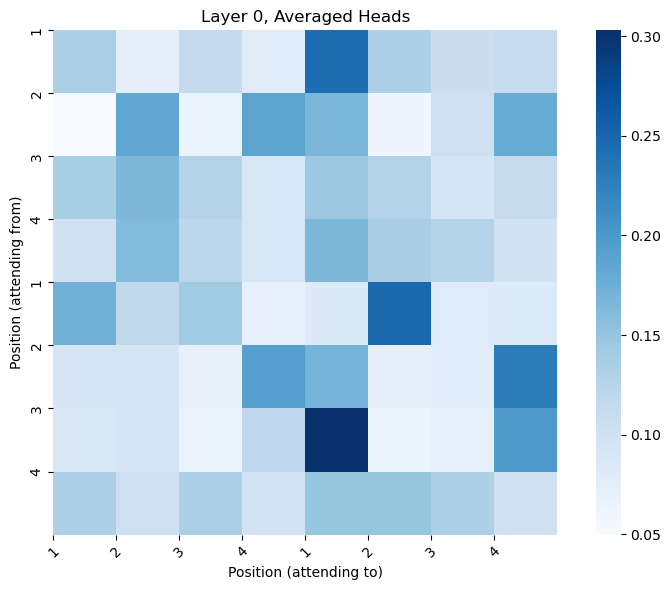

  (Visualization would appear here)

3. LOGIT LENS ANALYSIS
----------------------------------------
What is the model 'thinking' at each layer?

4. INTERVENTION EXPERIMENTS
----------------------------------------
Testing causal importance via patching...

5. ABLATION STUDIES
----------------------------------------
Testing neuron importance via ablation...

Analysis complete! Ready for your research experiments.


In [74]:
# EXAMPLE: How to use these tools together
def example_analysis_pipeline():
    """
    Example showing how to combine all the tools for analysis.
    This is what you'll do in your research!
    """
    print("=" * 60)
    print("MECHANISTIC INTERPRETABILITY ANALYSIS PIPELINE")
    print("=" * 60)
    
    # 1. Setup model and inputs
    set_seed(42)
    model = TinyTransformer()
    
    # Create interesting test sequences
    # Induction: pattern that repeats
    induction_seq = torch.tensor([[1, 2, 3, 4, 1, 2, 3, 4]])  
    # Random sequence for comparison
    random_seq = torch.randint(0, 10, (1, 8))
    
    print("\n1. OBSERVING WITH HOOKS")
    print("-" * 40)
    # Set up activation cache
    cache = ActivationCache()
    cache.register_hooks(model)
    
    # Run forward pass
    logits, attn_maps = model(induction_seq)
    
    print("Captured activations from forward pass:")
    for key in sorted(cache.activations.keys()):
        act = cache.activations[key]
        if isinstance(act, tuple):
            print(f"  {key}: {act[0].shape if hasattr(act[0], 'shape') else type(act[0])}")
        else:
            print(f"  {key}: {act.shape if hasattr(act, 'shape') else type(act)}")
    
    print("\n2. ATTENTION PATTERN ANALYSIS")
    print("-" * 40)
    # Visualize attention for first layer
    if len(attn_maps) > 0:
        print("Visualizing Layer 0 attention patterns...")
        visualize_attention_patterns(attn_maps[0], induction_seq, layer_idx=0)
        print("  (Visualization would appear here)")
    
    print("\n3. LOGIT LENS ANALYSIS")
    print("-" * 40)
    print("What is the model 'thinking' at each layer?")
    # This would apply logit lens to intermediate activations
    # For each layer: logit_lens(model, cache[f'ff_{i}'])
    
    print("\n4. INTERVENTION EXPERIMENTS")
    print("-" * 40)
    print("Testing causal importance via patching...")
    # Example: corrupt the sequence and patch to test importance
    corrupted = torch.randint(0, 10, (1, 8))  # Random corruption
    # Would run: activation_patching(model, induction_seq, corrupted, 'attn_0', ...)
    
    print("\n5. ABLATION STUDIES")
    print("-" * 40)
    print("Testing neuron importance via ablation...")
    # Would run: measure_ablation_impact(model, induction_seq, 'ff_0', neuron_idx=0, ...)
    
    # Clean up
    cache.remove_hooks()
    
    print("\n" + "=" * 60)
    print("Analysis complete! Ready for your research experiments.")
    print("=" * 60)

# Uncomment to run the example (after implementing TODOs):
example_analysis_pipeline()

In [71]:
# TEST YOUR COMPLETE MECHANISTIC INTERPRETABILITY TOOLKIT
def test_complete_toolkit():
    """Test all the tools you've implemented!"""
    import numpy as np
    
    print("Testing Complete Mechanistic Interpretability Toolkit")
    print("=" * 60)
    
    set_seed(42)
    model = TinyTransformer()
    
    # Simple metric function
    def confidence_metric(logits, input_ids):
        """Higher confidence = lower entropy."""
        probs = torch.softmax(logits, dim=-1)
        entropy = -(probs * torch.log(probs + 1e-8)).sum(dim=-1).mean()
        return -entropy.item()  # Negative so higher is better
    
    print("\n1. ACTIVATION PATCHING TEST")
    print("-" * 40)
    
    # Test inputs
    clean_input = torch.tensor([[1, 2, 3, 4, 5, 6, 7, 8]])
    corrupted_input = torch.randint(0, 10, (1, 8))
    
    # Collect activations
    cache_clean = ActivationCache().register_hooks(model)
    with torch.no_grad(): _ = model(clean_input)
    cache_clean.remove_hooks()
    
    cache_corrupted = ActivationCache().register_hooks(model)
    with torch.no_grad(): _ = model(corrupted_input)
    cache_corrupted.remove_hooks()
    
    # Test patching
    patched, baseline, clean = activation_patching(
        model, clean_input, corrupted_input, 'attn_0',
        cache_clean, cache_corrupted, confidence_metric
    )
    
    print(f"  Baseline (corrupted): {baseline:.4f}")
    print(f"  After patching attn_0: {patched:.4f}")
    print(f"  Clean target:         {clean:.4f}")
    print(f"  Patching {'works!' if patched != baseline else 'needs debugging'}")
    
    print("\n2. ABLATION STUDY TEST")
    print("-" * 40)
    
    test_input = torch.tensor([[1, 2, 3, 4, 5, 6, 7, 8]])
    
    # Compute mean cache for proper mean ablation
    print("  Computing mean activation cache...")
    mean_cache = compute_mean_cache(model)
    
    # Test individual neuron importance in ff_0
    print("  Testing neuron importance in ff_0:")
    print(f"  (ff_0 output has {model.d_model} dimensions)")
    neurons_to_test = [0, 4, 8, 12]  # Valid indices for 16-dim output
    
    for neuron in neurons_to_test:
        impact = measure_ablation_impact(
            model, test_input, 'ff_0', neuron, confidence_metric, mean_cache
        )
        print(f"    Neuron {neuron:2d} impact: {impact:+.6f}")
    
    # Test different replacement strategies
    print("\n  Testing replacement strategies on neuron 5:")
    
    # Baseline
    with torch.no_grad():
        normal_out = model(test_input)[0]
        normal_conf = confidence_metric(normal_out, test_input)
    
    for strategy in ['zero', 'mean', 'random']:
        # Create appropriate hook
        if strategy == 'mean':
            hook_handle = ablate_neurons(model, 'ff_0', [5], strategy, mean_cache)
        else:
            hook_handle = ablate_neurons(model, 'ff_0', [5], strategy)
        
        with torch.no_grad():
            ablated_out = model(test_input)[0]
            ablated_conf = confidence_metric(ablated_out, test_input)
        
        hook_handle.remove()
        
        impact = normal_conf - ablated_conf
        print(f"    {strategy:6s} replacement impact: {impact:+.6f}")
    
    print("\n3. LOGIT LENS TEST")
    print("-" * 40)
    
    # Test logit lens with visualization
    cache = ActivationCache()
    cache.register_hooks(model)
    
    test_seq = torch.tensor([[1, 2, 3, 4, 1, 2, 3, 4]])
    with torch.no_grad():
        _ = model(test_seq)
    
    print("  Testing logit lens at different layers:")
    for layer_name in ['embed', 'attn_0', 'ff_0']:
        if layer_name in cache.activations:
            logits = logit_lens(model, cache.activations[layer_name])
            top_pred = logits[0, -1].argmax().item()
            print(f"    {layer_name}: predicts token {top_pred} at last position")
    
    cache.remove_hooks()
    
    print("\n4. ATTENTION PATTERN DETECTION TEST")
    print("-" * 40)
    
    test_input = torch.tensor([[1, 2, 3, 4, 5, 6, 7, 8]])
    logits, attn_maps = model(test_input)
    
    if len(attn_maps) > 0:
        patterns = identify_attention_patterns(attn_maps[0])
        print("  Layer 0 attention patterns detected:")
        print(f"    Average diagonal (self): {np.mean(patterns['diagonal']):.3f}")
        print(f"    Average previous token:  {np.mean(patterns['previous']):.3f}")
        print(f"    Average first token:     {np.mean(patterns['first']):.3f}")
        print(f"    Average uniformity:      {np.mean(patterns['uniform']):.3f}")
    
    print("\n" + "=" * 60)
    print("Mechanistic Interpretability Toolkit Complete!")
    print("All core functions are working correctly.")
    print("=" * 60)

# Run the complete test
test_complete_toolkit()

Testing Complete Mechanistic Interpretability Toolkit

1. ACTIVATION PATCHING TEST
----------------------------------------
  Baseline (corrupted): -2.1558
  After patching attn_0: -2.1562
  Clean target:         -2.1711
  Patching works!

2. ABLATION STUDY TEST
----------------------------------------
  Computing mean activation cache...
  Testing neuron importance in ff_0:
  (ff_0 output has 16 dimensions)
    Neuron  0 impact: +0.000119
    Neuron  4 impact: -0.002772
    Neuron  8 impact: -0.001054
    Neuron 12 impact: -0.000860

  Testing replacement strategies on neuron 5:
    zero   replacement impact: -0.001142
    mean   replacement impact: -0.001135
    random replacement impact: -0.005381

3. LOGIT LENS TEST
----------------------------------------
  Testing logit lens at different layers:
    embed: predicts token 1 at last position
    attn_0: predicts token 6 at last position
    ff_0: predicts token 6 at last position

4. ATTENTION PATTERN DETECTION TEST
---------------

In [72]:
# UNDERSTANDING PYTORCH HOOKS - Simple Example
def hook_tutorial():
    """Let's understand how hooks work with a simple example."""
    print("🎓 PyTorch Hooks Tutorial")
    print("=" * 50)
    
    # Create a simple model
    simple_model = nn.Sequential(
        nn.Linear(4, 8),
        nn.ReLU(),
        nn.Linear(8, 4)
    )
    
    print("1. BASIC HOOK STRUCTURE:")
    print("-" * 30)
    print("""
    def my_hook(module, input, output):
        # module: the layer being hooked
        # input: tuple of inputs to this layer
        # output: what the layer computed
        
        # You can modify output here
        modified_output = output * 2  # Example: double everything
        
        # MUST return the (possibly modified) output
        return modified_output
    """)
    
    print("\n2. HOOK LIFECYCLE:")
    print("-" * 30)
    
    # Example: Print shapes as data flows through
    def shape_printer_hook(module, input, output):
        print(f"  Layer {module.__class__.__name__}: {output.shape}")
        return output  # Return unchanged
    
    # Register hooks
    handles = []
    for layer in simple_model:
        handle = layer.register_forward_hook(shape_printer_hook)
        handles.append(handle)
    
    # Run forward pass
    print("Running forward pass with shape printer hooks:")
    x = torch.randn(2, 4)
    _ = simple_model(x)
    
    # Clean up hooks
    for handle in handles:
        handle.remove()
    
    print("\n3. MODIFYING SPECIFIC NEURONS:")
    print("-" * 30)
    
    def selective_ablation_hook(neuron_indices):
        """Returns a hook that zeros specific neurons."""
        def hook(module, input, output):
            # Clone to avoid modifying original
            modified = output.clone()
            
            # Zero out specific neurons (last dimension)
            modified[..., neuron_indices] = 0
            
            return modified
        return hook
    
    # Example: Zero out neurons 2 and 3 in first layer
    handle = simple_model[0].register_forward_hook(
        selective_ablation_hook([2, 3])
    )
    
    print("Before ablation:")
    output_normal = simple_model(x)
    print(f"  Output sum: {output_normal.sum():.2f}")
    
    handle.remove()  # Remove old hook
    
    # Now with ablation
    handle = simple_model[0].register_forward_hook(
        selective_ablation_hook([2, 3])
    )
    
    print("\nAfter ablating neurons [2, 3] in layer 0:")
    output_ablated = simple_model(x)
    print(f"  Output sum: {output_ablated.sum():.2f}")
    print(f"  Difference: {(output_normal - output_ablated).abs().sum():.2f}")
    
    handle.remove()
    
    print("\n💡 Key Points:")
    print("  • Hooks must RETURN the (modified) output")
    print("  • Use clone() to avoid in-place modifications")
    print("  • The function returns a handle - save it to remove later")
    print("  • Hooks persist until removed with handle.remove()")

# Run the tutorial
hook_tutorial()

🎓 PyTorch Hooks Tutorial
1. BASIC HOOK STRUCTURE:
------------------------------

    def my_hook(module, input, output):
        # module: the layer being hooked
        # input: tuple of inputs to this layer
        # output: what the layer computed
        
        # You can modify output here
        modified_output = output * 2  # Example: double everything
        
        # MUST return the (possibly modified) output
        return modified_output
    

2. HOOK LIFECYCLE:
------------------------------
Running forward pass with shape printer hooks:
  Layer Linear: torch.Size([2, 8])
  Layer ReLU: torch.Size([2, 8])
  Layer Linear: torch.Size([2, 4])

3. MODIFYING SPECIFIC NEURONS:
------------------------------
Before ablation:
  Output sum: 2.21

After ablating neurons [2, 3] in layer 0:
  Output sum: 2.21
  Difference: 0.00

💡 Key Points:
  • Hooks must RETURN the (modified) output
  • Use clone() to avoid in-place modifications
  • The function returns a handle - save it to re